(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


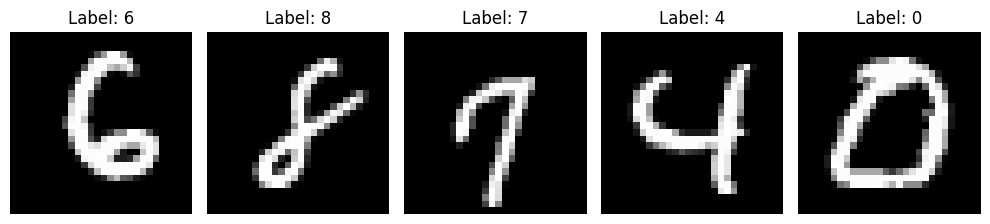

In [25]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load the dataset as training and testing, then print out the shapes of the data matrices
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

# Display 5 random handwritten images from train_X and corresponding labels
import random
num_images = 5
random_indices = random.sample(range(train_X.shape[0]), num_images)
plt.figure(figsize=(10,5)) # Set the figure size
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(train_X[idx], cmap='gray')
    plt.title(f"Label: {train_y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

def extract_digits(X, y, d1, d2):
    assert d1 in range(0, 10), "d1 should be a number between 0 and 9 inclusive"
    assert d2 in range(0, 10), "d2 should be a number between 0 and 9 inclusive"
    # Get the indices where Labels are d1 or d2
    indices = np.where((y == d1) | (y == d2))[0]
    # Extract the corresponding samples and Labels
    X_extracted = X[indices]
    y_extracted = y[indices]
    return (X_extracted, y_extracted)

def vectorize_images(X):
    # Vectorize the images
    X_vectorized = X.reshape(X.shape[0], -1)
    # Transpose the vectorized result
    X_transposed = X_vectorized.T
    # Normalize the pixel values (divide each column by its max value)
    X_normalized = X_transposed / X_transposed.max(axis=0)
    return X_vectorized

# Extract images and Labels for digits 1 and 5 from training and testing sets
train_X_1_5, train_y_1_5 = extract_digits(train_X, train_y, 1, 5)
test_X_1_5, test_y_1_5 = extract_digits(test_X, test_y, 1, 5)
# Vectorize, transpose, and normalize the images
train_X_1_5 = vectorize_images(train_X_1_5)
test_X_1_5 = vectorize_images(test_X_1_5)
# Convert the labels
train_class_1_5 = np.where(train_y_1_5 == 1, 0, 1) # Convert 1 -> 0 and 5 -> 1
test_class_1_5 = np.where(test_y_1_5 == 1, 0, 1)

def sigmoid(Z):
    # Handling overflow by clipping the input to avoid large negative numbers
    Z = np.clip(Z, -500, 500)
    sigma = 1 / (1 + np.exp(-Z)) # Sigmoid function
    return sigma

def deriv_sigmoid(Y):
    sigma_prime = Y * (1 - Y) # Derivative of sigmoid: σ'(z) = σ(z) * (1 - σ(z))
    return sigma_prime

def ReLu(Z):
    relu = np.maximum(0, Z)
    return relu

def deriv_ReLu(Y):
    relu_prime = np.where(Y > 0, 1, 0)
    return relu_prime

class NNet:
    def __init__(self, input_size=784, output_size=1, batch_size=1000, hidden_layers=[1000, 500]):
        self.Y = []
        self.Z = []
        self.W = []
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layers = hidden_layers
        layers = [input_size] + hidden_layers + [output_size]
        L = len(hidden_layers) + 1
        for i in range(1, L + 1):
            self.Y.append(np.zeros((layers[i], batch_size)))
            self.Z.append(np.zeros((layers[i], batch_size)))
            self.W.append(2 * (np.random.rand(layers[i], layers[i-1] + 1) - 0.5))

    def feedforward (self, X):
    #TODO
        L = len(self.hidden_layers) + 1
        Y = [None] * L
        Z = [None] * L
        Y[0] = X  # Input to the first layer

        for l in range(1, L):
            if l == 1:
                # Add a row of ones to accommodate the bias term for the first layer
                Y_prev = np.vstack([Y[0], np.ones((1, Y[0].shape[1]))])
            else:
                # Add a row of ones to accommodate the bias term for subsequent layers
                Y_prev = np.vstack([Y[l - 1], np.ones((1, Y[l - 1].shape[1]))])

            # Calculate Z(l) with bias
            Z[l] = np.dot(self.W[l - 1], Y_prev)

            if l < L - 1:
                Y[l] = self.sigmoid(Z[l])  # Apply sigmoid activation to hidden layers
            else:
                Y[l] = self.sigmoid(Z[l])  # Apply sigmoid activation to output layer

        self.Y = Y  # Store computed Y's in the model
        self.Z = Z  # Store computed Z's in the model
        return self  # Return the modified model


    def backpropagation(self, X, Y, eta=0.01):
        model = self.feedforward(X)
        L = len(model.Y)
        dC_dZ = [np.zeros_like(Z) for Z in model.Z]
        dC_dw = [np.zeros_like(W) for W in model.W]
        dC_dY_prev = [np.zeros_like(Y) for Y in model.Y]
        dC_dY_L = model.Y[-1] - Y
        dC_dZ[-1] = deriv_sigmoid(model.Y[-1]) * dC_dY_L
        for l in reversed(range(1, L)):
            dC_dw[l] = np.dot(dC_dZ[l], np.vstack((model.Y[l-1], np.ones((1, model.batch_size)))))
            dC_dY_prev[l-1] = np.dot(model.W[l].T, dC_dZ[l])[:-1, :]
            dC_dZ[l-1] = deriv_ReLu(model.Y[l-1]) * dC_dY_prev[l-1]
        for l in range(L):
            model.W[l] -= eta * dC_dw[l]
        return model

def train_NNet(X, Y, epochs=20, batch_size=1000, eta=0.01):
    num_samples = X.shape[1] # Assuming X has shape (features, samples)
    # Convert Y to a 2D array if it's 1D
    if Y.ndim == 1:
        Y = Y[:, np.newaxis]
    # Initialize the model (assumes a proper NNet class exists)
    model = NNet(hidden_layers=[500, 250]) # Example initialization
    cost_history = []
    weight_changes = []
    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[:, indices]
        Y = Y[indices] # No need for additional axis
        # Process data in mini-batches
   
        for i in range(0, num_samples, batch_size):
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[i:i+batch_size]
            
            # Feedforward
            model = model.feedforward(X_batch)
            # Backpropagation
            model = model.backpropagation(X_batch, Y_batch, eta)
            # Compute cost
            model = model.feedforward(X)
            Y_pred = model.Y[-1]
            cost = np.mean(np.square(Y_pred - Y))
            cost_history.append(cost)
            # Compute weight changes
            weight_change = np.sum([np.linalg.norm(w) for w in model.W])
            weight_changes.append(weight_change)
            print(f"Epoch {epoch + 1}/{epochs}, Cost: {cost}, Weight change: {weight_change}")
        # Plot cost history
        plt.figure()
        plt.plot(cost_history)
        plt.title('Cost History')
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.show()
        # Plot weight changes
        plt.figure()
        plt.plot(weight_changes)
        plt.title('Weight Change History')
        plt.xlabel('Epoch')
        plt.ylabel('Weight Change')
        plt.show()
    return model

def test_model(test_data, test_labels, model, d1, d2):
    L = len(model.hidden_layers) + 1
    Y = test_data
    for i in range(L):
        Z = np.matmul(model.W[i], np.append(Y, np.array([np.ones(Y.shape[1])]), axis=0))
        if i < L - 1:
            Y = ReLu(Z)
        else:
            Y = sigmoid(Z)
    Y = np.where(Y >= 0.5, 1, 0)
    Y_predicted = np.where(Y == 0, d1, d2)
    acc = accuracy_score(test_labels, Y_predicted)
    return (acc, Y_predicted)

def evaluate_model(test_data, test_labels, model, d1, d2):
    acc, Y_predicted = test_model(test_data, test_labels, model, d1, d2)
    cm = confusion_matrix(test_labels, Y_predicted, labels=[d1, d2])
    return acc, cm

def hyperparameter_tuning(train_X, train_y, test_X, test_y, batch_sizes, etas, hidden_layers_options):
    best_accuracy = 0
    best_params = None
    for batch_size in batch_sizes:
        for eta in etas:
            for hidden_layers in hidden_layers_options:
                model = NNet(hidden_layers=hidden_layers)
                model = train_NNet(train_X, train_y, epochs=20, batch_size=batch_size, eta=eta)
                acc, cm = evaluate_model(test_X, test_y, model, 1, 5)
                print(f"Batch size: {batch_size}, eta: {eta}, Hidden layers: {hidden_layers}, accuracy: {acc}")
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_params = (batch_size, eta, hidden_layers)
                    best_cm = cm
    print(f"Best accuracy: {best_accuracy} with batch size: {best_params[0]}, eta: {best_params[1]}, hidden layers: {best_params[2]}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 5], yticklabels=[1, 5])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [24]:
# Parameters for training
batch_sizes = [1000]
etas = [0.01]
hidden_layers_options = [[500, 250]]

# Train the model
model = hyperparameter_tuning(train_X_1_5, train_class_1_5, test_X_1_5, test_class_1_5, batch_sizes, etas, hidden_layers_options)

# Evaluate the model
accuracy, confusion_mat = evaluate_model(test_X_1_5, test_class_1_5, model, 1, 5)
print(f"Test accuracy: {accuracy}")
print(f"Confusion matrix:\n{confusion_mat}")


ValueError: shapes (500,785) and (12164,784) not aligned: 785 (dim 1) != 12164 (dim 0)